In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = sin.(features*[1, -1, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + cos.(features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0]);


In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     5.83606   …  8.61508   1.0   1.16564
 4.43494   8.65398   4.38668    8.66793      5.79587   0.0  -0.68458
 7.45673   7.98071   9.35901    5.96536      9.99516   0.0  -0.724428
 5.12083   8.25448   8.79223    2.87236      8.06585   0.0   0.943837
 2.53849   5.30423   5.84012    9.7704       9.6668    0.0  -0.782951
 3.34152   2.66141   9.8669     9.76664   …  9.49805   1.0   1.61089
 4.27328   8.75436   0.0258112  0.863643     2.24987   1.0   0.0615018
 8.67547   7.27313   0.151025   4.99536      0.765286  0.0   0.995451
 0.991336  1.20752   5.87184    3.17045      9.81301   0.0  -0.386758
 1.25287   6.88003   3.64868    5.80333      3.00126   0.0   0.431152
 6.92209   0.298644  4.84843    8.11503   …  1.49476   0.0   0.288635
 1.36551   1.07227   0.570038   1.05282      7.60498   1.0  -0.249938
 0.320967  6.45858   4.85281    2.0843       1.98433   0.0   0.288252
 ⋮                                        ⋱            ⋮    
 1.41

In [4]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_7.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = sin.(Xtest_1[:, 1]-Xtest_1[:, 2]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1]-Xtest[:, 2])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.33956758412286364
2.0527879676021725e-5


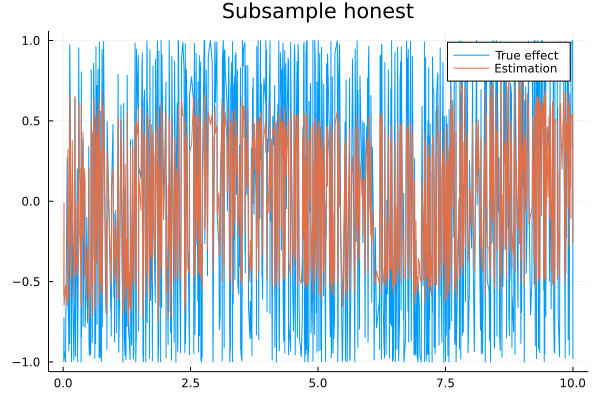

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [9]:
get_freq(cf, 3)

Dict{Any, Float64} with 10 entries:
  5  => 0.03223
  4  => 0.0264228
  6  => 0.0197445
  7  => 0.0229384
  2  => 0.385308
  10 => 0.00958188
  9  => 0.0252613
  8  => 0.0336818
  3  => 0.0194541
  1  => 0.425377

In [10]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0554717
  4  => 0.0512453
  6  => 0.0457358
  7  => 0.0412075
  2  => 0.296
  10 => 0.0370566
  9  => 0.0452075
  8  => 0.0510943
  3  => 0.0418868
  1  => 0.335094

In [11]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0807553
  4  => 0.078082
  6  => 0.0738126
  7  => 0.0736569
  2  => 0.189333
  10 => 0.0740462
  9  => 0.075279
  8  => 0.0779003
  3  => 0.077511
  1  => 0.199624

### Bootstrap

In [12]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1]-Xtest[:, 2])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

0.4259446056567373
3.008909075982602e-5


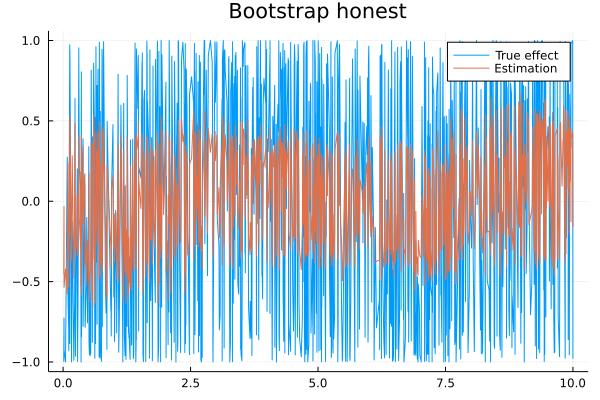

In [13]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [14]:
get_freq(cf, 3)

Dict{Any, Float64} with 10 entries:
  5  => 0.0361021
  4  => 0.0428529
  6  => 0.0343411
  7  => 0.0322865
  2  => 0.338714
  10 => 0.0272967
  9  => 0.0399178
  8  => 0.0449075
  3  => 0.0381567
  1  => 0.365424

In [15]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0632931
  4  => 0.0671078
  6  => 0.0569093
  7  => 0.0541067
  2  => 0.250058
  10 => 0.0553523
  9  => 0.0603348
  8  => 0.0685091
  3  => 0.0604126
  1  => 0.263916

In [16]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0847545
  4  => 0.0868846
  6  => 0.0832884
  7  => 0.0833887
  2  => 0.158332
  10 => 0.0823361
  9  => 0.0832884
  8  => 0.0879873
  3  => 0.0889145
  1  => 0.160825